<a href="https://colab.research.google.com/github/giommazz/kaggle-bike-sharing/blob/main/bike%E2%80%91sharing%E2%80%91solution_day.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sixt Data Science Lab - Test Task for Data Scientist Job Candidates

## Introduction

In this test task you will have an opportunity to demonstrate your skills of a Data Scientist from various angles - processing data, analyzing and visualizing it, finding insights, applying predictive techniques and explaining your reasoning about it.

The task is based around a bike sharing dataset openly available at UCI Machine Learning Repository [1].

Please go through the steps below, build up the necessary code and comment on your choices.

## Part 1 - Data Loading and Environment Preparation

**Tasks:**
1. Prepare a Python 3 virtual environment (with virtualenv command). `requirements.txt` output of `pip freeze` command should be included as part of your submission.
2. Load the data from UCI Repository and put it into the same folder with the notebook. The link to it is https://archive.ics.uci.edu/ml/datasets/bike+sharing+dataset . Here is an available mirror in case the above website is down: https://data.world/uci/bike-sharing-dataset
3. We split the data into two parts. One dataset containing the last 30 days and one dataset with the rest.

In [ ]:
##########################################
# 1.2)  Load the data from UCI Repository and put it into the same folder with the notebook.

# Create `data` directory, if it doesn't exist
!mkdir -p data

# Download the zipped archive from UCI
!wget -q --show-progress -P data http://archive.ics.uci.edu/ml/machine-learning-databases/00275/Bike-Sharing-Dataset.zip

# Unzip to get `hour.csv`, `day.csv`, `Readme.txt`
!unzip -q data/Bike-Sharing-Dataset.zip -d data

Bike-Sharing-Datase     [   <=>              ] 273.43K   613KB/s    in 0.4s    


In [ ]:
##########################################
# IMPORTS
##########################################
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.base import clone, BaseEstimator, TransformerMixin
from sklearn.model_selection import BaseCrossValidator, cross_val_score
from sklearn.metrics import root_mean_squared_log_error
from sklearn.compose import ColumnTransformer, TransformedTargetRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
import inspect

## Part 2 - Data Processing and Analysis

**Tasks:**
1. Perform all needed steps to load and clean the data. Please comment the major steps of your code.
2. Visualise rentals of bikes per day.
3. Assume that each bike has exactly maximum 12 rentals per day.
    * Find the maximum number of bicycles `nmax` that was needed in any one day.
    * Find the 95%-percentile of bicycles `n95` that was needed in any one day.
5. Visualize the distribution of the covered days depending on the number of available bicycles (e.g. `nmax` bicycles would cover 100% of days, `n95` covers 95%, etc.)


In [ ]:
##########################################
# 2.1)  Perform all needed steps to load and clean the data. Please comment the major steps of your code.
##########################################
# 2.1.1) Read raw data
day_df = pd.read_csv('data/day.csv')
print(f"Daily dataset: {day_df.shape[0]} rows × {day_df.shape[1]} cols\n")
print(f"Its columns are {day_df.columns.values}")
print(f'Raw data: {day_df.head(2)}')
print()

Daily dataset: 731 rows × 16 cols

Its columns are ['instant' 'dteday' 'season' 'yr' 'mnth' 'holiday' 'weekday' 'workingday'
 'weathersit' 'temp' 'atemp' 'hum' 'windspeed' 'casual' 'registered' 'cnt']
Raw data:    instant      dteday  season  yr  mnth  holiday  weekday  workingday  \
0        1  2011-01-01       1   0     1        0        6           0   
1        2  2011-01-02       1   0     1        0        0           0   

   weathersit      temp     atemp       hum  windspeed  casual  registered  \
0           2  0.344167  0.363625  0.805833   0.160446     331         654   
1           2  0.363478  0.353739  0.696087   0.248539     131         670   

   cnt  
0  985  
1  801  



### Remarks about the cell below
Instead of dropping `casual` and `registered`, one could, alternatively:
1. train two separate models, one to predict `registered` and the other one to predict `casual`;
2. then, sum the two predictions to yield `cnt`

Pros: potentially better adaptability.
Cons:
- double training time. This might be negligible for decision trees, but this depend on their size (e.g. number of estimators) or training criteria (e.g.impurity criterion)
- prediction errors might add up more than by just predicting the single target `cnt`

In [ ]:
##########################################
# 2.1.2) No missing values by assumption
##########################################
# 2.1.3) Create new index and drop uninformative and leaking columns
day_df['date'] = pd.to_datetime(day_df['dteday']) # Create new column from 'dteday' with datetime format
day_df.set_index('date', inplace=True) # 'date' is unique ID -> set as DataFrame index
# Drop 'instant' (just an ID), 'dteday' (now redundant), 'casual' and 'registered' (risk of target leakage)
day_df = day_df.drop(columns=['instant', 'dteday', 'casual', 'registered'])
print(f'Columns after dropping uninformative and leaky ones: {day_df.columns}')
print()
# Statistics
print(day_df.describe())
print()

Columns after dropping uninformative and leaky ones: Index(['season', 'yr', 'mnth', 'holiday', 'weekday', 'workingday',
       'weathersit', 'temp', 'atemp', 'hum', 'windspeed', 'cnt'],
      dtype='object')

           season          yr        mnth     holiday     weekday  workingday  \
count  731.000000  731.000000  731.000000  731.000000  731.000000  731.000000   
mean     2.496580    0.500684    6.519836    0.028728    2.997264    0.683995   
std      1.110807    0.500342    3.451913    0.167155    2.004787    0.465233   
min      1.000000    0.000000    1.000000    0.000000    0.000000    0.000000   
25%      2.000000    0.000000    4.000000    0.000000    1.000000    0.000000   
50%      3.000000    1.000000    7.000000    0.000000    3.000000    1.000000   
75%      3.000000    1.000000   10.000000    0.000000    5.000000    1.000000   
max      4.000000    1.000000   12.000000    1.000000    6.000000    1.000000   

       weathersit        temp       atemp         hum   winds

### Remarks about the cell below
- the `iqr_mask()` function could be computed with Pandas' `quantile([0.25, 0.75])` as well
- the only column with a seemingly weird value seems to be `hum`, with a row being `0.0`: Washington is rearely so dry. Outlier flag!


In [ ]:
##########################################
# 2.1.4) Outlier detection
def iqr_mask(pd_series, pval_low, pval_high, coeff):
    """
        Return a Boolean mask that flags Tukey outliers (typically values outside [Q1 - c*IQR, Q3 + c*IQR]).
    """
    assert pval_low < pval_high, "`pval_low` should be smaller than `pval_hihg`"
    perc_low, perc_high = np.percentile(pd_series, [pval_low, pval_high])
    range = perc_high - perc_low # compute interequartile range
    # compute bounds: beyond them lie outliers
    lower, upper = perc_low - coeff * range, perc_high + coeff * range
    outlier_mask = (pd_series < lower) | (pd_series > upper)
    print(f"Tukey outliers with ± {coeff}*{range} ({pval_low}-{pval_high}):\
          {outlier_mask.sum()} days ({outlier_mask.mean():.2%} of data)")
    print(f'The outliers are: {pd_series[outlier_mask].values}')

print()
iqr_mask(day_df['hum'], 25, 75, 1.5)
# Replace outlier with humidity value from previous day
outlier_humidity_mask = day_df['hum'] == 0
day_df.loc[outlier_humidity_mask, 'hum'] = day_df['hum'].shift(1)[outlier_humidity_mask]
print()


Tukey outliers with ± 1.5*0.21020850000000002 (25-75):          2 days (0.27% of data)
The outliers are: [0.187917 0.      ]



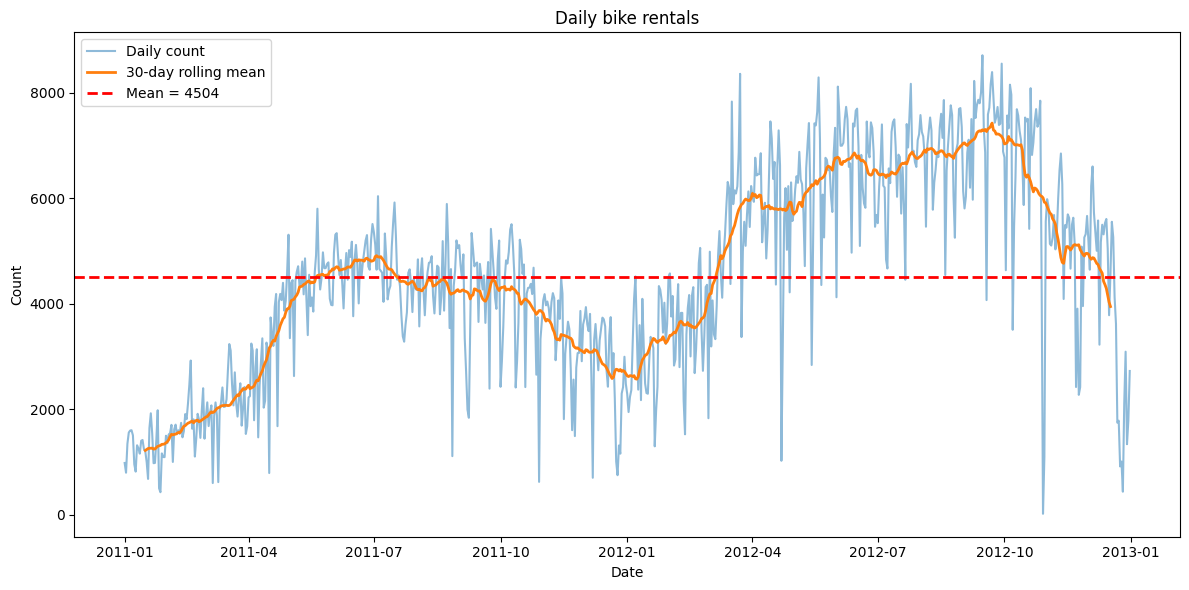

In [ ]:
##########################################
# 2.2)  Visualize rentals of bikes per day
##########################################
# 2.2.1) plot mean, rentals and rolling rentals
mean_cnt = day_df['cnt'].mean()
window = 30
# `center=True` centers the rolling window (instead of right aligned)
rolling_mean = day_df['cnt'].rolling(window=window, center=True).mean()
plt.figure(figsize=(12, 6))
# alpha sets some transparency for the daily count curve
plt.plot(day_df.index, day_df['cnt'], label='Daily count', alpha=0.5)
plt.plot(day_df.index, rolling_mean, label=f'{window}-day rolling mean', linewidth=2)
plt.axhline(mean_cnt, color='red', linestyle='--', linewidth=2, label=f'Mean = {mean_cnt:.0f}')
plt.title('Daily bike rentals')
plt.xlabel('Date')
plt.ylabel('Count')
plt.legend()
plt.tight_layout()
plt.show()

### Remarks about the two cells below
- The distribution is almost normal-like. However...
- ...multimodality detected (3 peaks/clusters): potentially corresponding to 3 seasons? (maybe winter, summer, shoulder season);
- Presence of some extreme lows/highs, which might be outliers, or not: they could correspond to extremely pleasant days, or very snowy days. Below I applied the Tukey's IQR rule to exclude potential outliers. I found basically no outliers. The extreme points probably correspond to exceptionally bad or good weather days
- log-transform is left-skewed (log compresses high values and sparsifies small ones)

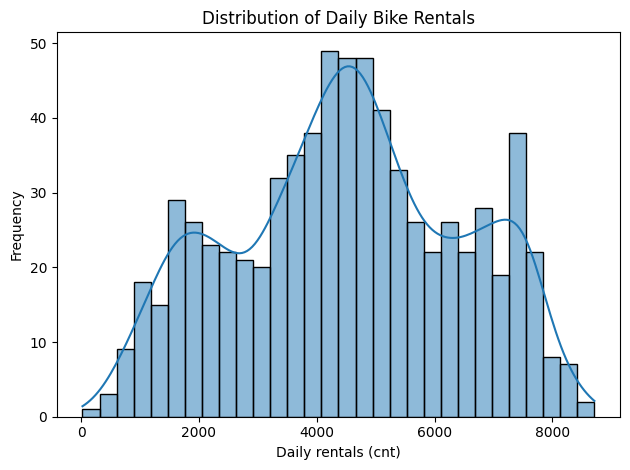

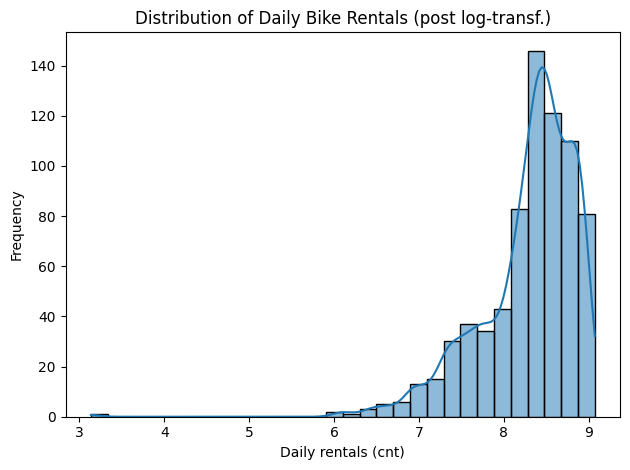

In [ ]:
##########################################
# 2.2.2) Plot marginal distribution (histogram bars and related KDE) of `cnt`
sns.histplot(day_df['cnt'], bins=30, kde=True, kde_kws={'bw_adjust':0.7})
plt.title('Distribution of Daily Bike Rentals')
plt.xlabel('Daily rentals (cnt)')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()
# sns.pairplot(day_df)
##########################################
# 2.2.3) Plot marginal distribution (histogram bars and related KDE) of `cnt` *after* log-transform
transformed = np.log1p(day_df['cnt'])
sns.histplot(transformed, bins=30, kde=True, kde_kws={'bw_adjust':0.7})
plt.title('Distribution of Daily Bike Rentals (post log-transf.)')
plt.xlabel('Daily rentals (cnt)')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

In [ ]:
##########################################
# 2.2.4) Outlier detection and elimination
# traditional outlier range
iqr_mask(day_df['cnt'], 25, 75, 1.5)
# loosened outlier range
iqr_mask(day_df['cnt'], 25, 75, 1.0)

Tukey outliers with ± 1.5*2804.0 (25-75):          0 days (0.00% of data)
The outliers are: []
Tukey outliers with ± 1.0*2804.0 (25-75):          1 days (0.14% of data)
The outliers are: [22]


### Remarks about the cell below
It doesn't look like `weekday` should have a large predictive power, as a feature. Later, I tried removing it and training RFs without it. Since it improves the error, although very marginally, I decided to keep it

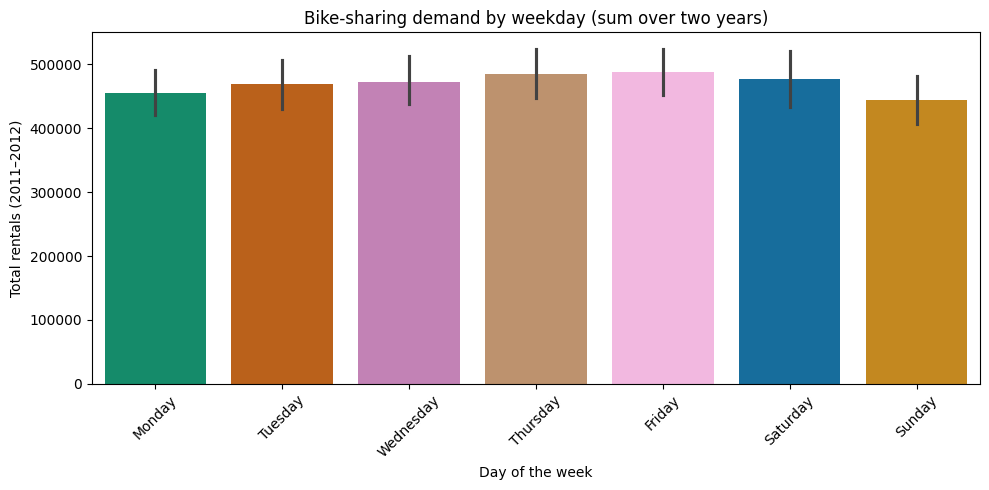

In [ ]:
##########################################
# 2.2.5) Visualize total bike rental count per weekday
plot_day_df = day_df.copy() # Add readable weekday column
plot_day_df['day_of_week'] = plot_day_df.index.day_name()
# Displayed names, ordered
dow_order = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
plt.figure(figsize=(10,5))
sns.barplot(
    data = plot_day_df,
    x = 'day_of_week',
    y = 'cnt',
    estimator = sum, # aggregate by sum of rentals
    order = dow_order, # keep calendar order
    hue='day_of_week',
    dodge=False, # avoid side-by-side bars
    legend=False, # no legend needed since x-axis already labels
    palette = sns.color_palette("colorblind", 7)
)
plt.xlabel('Day of the week')
plt.ylabel('Total rentals (2011–2012)')
plt.title('Bike-sharing demand by weekday (sum over two years)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

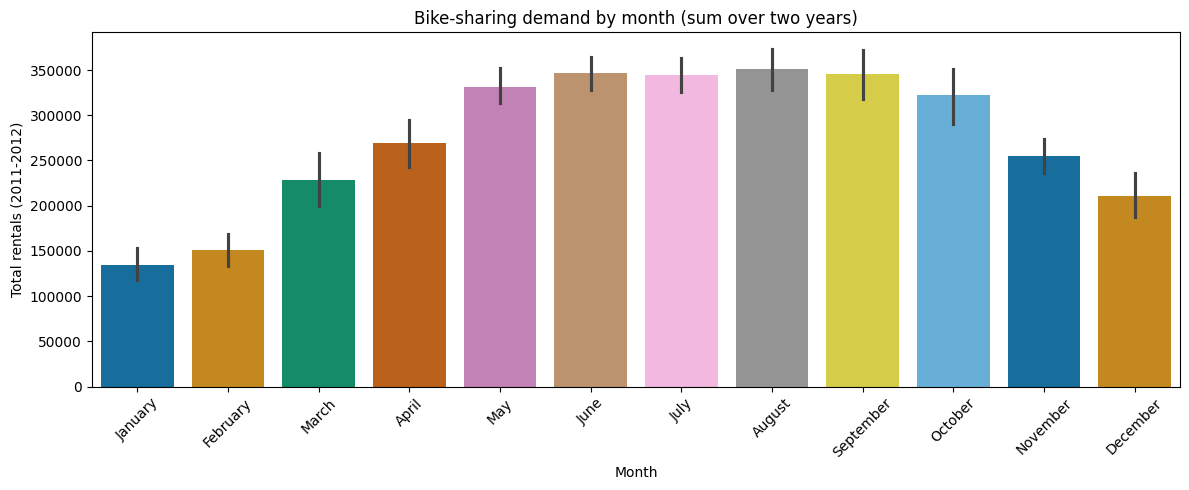

In [ ]:
##########################################
# 2.2.6) Visualize total bike rental count per  month
plot_day_df = day_df.copy() # Add readable month column
plot_day_df['month_name'] = plot_day_df.index.month_name()
# Displayed names, ordered
month_order = ['January','February','March','April','May','June',
               'July','August','September','October','November','December']
plt.figure(figsize=(12,5))
sns.barplot(
    data=plot_day_df,
    x='month_name',
    y='cnt',
    estimator=sum, # aggregate by sum of rentals
    order=month_order,
    hue='month_name',
    dodge=False,
    legend=False,
    palette=sns.color_palette("colorblind", 12)
)

plt.xlabel('Month')
plt.ylabel('Total rentals (2011-2012)')
plt.title('Bike-sharing demand by month (sum over two years)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

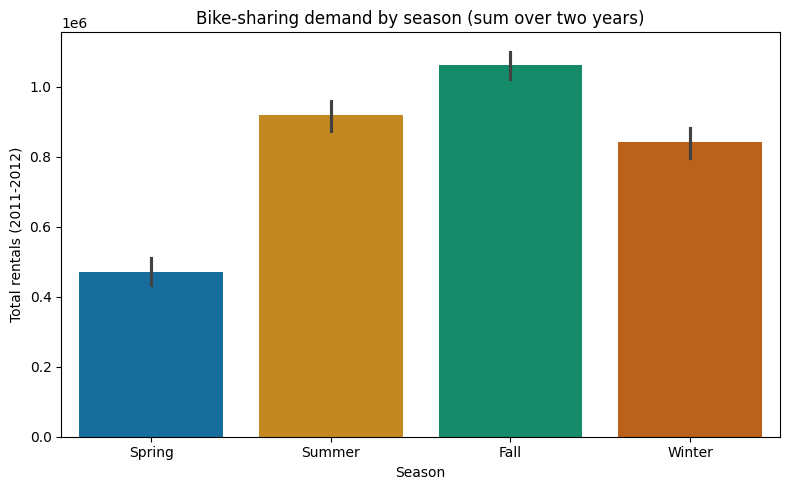

In [ ]:
##########################################
# 2.2.7) Visualize total bike rental count per season
plot_day_df = day_df.copy()
season_map = {1: 'Spring', 2: 'Summer', 3: 'Fall', 4: 'Winter'} # Map numeric season codes to names
plot_day_df['season_name'] = plot_day_df['season'].map(season_map)
season_order = ['Spring', 'Summer', 'Fall', 'Winter'] # Displayed names, ordered
plt.figure(figsize=(8,5))
sns.barplot(
    data = plot_day_df,
    x = 'season_name',
    y = 'cnt',
    estimator = sum,
    order = season_order,
    hue='season_name',
    dodge=False,
    legend=False,
    palette = sns.color_palette("colorblind", 4)
)
plt.xlabel('Season')
plt.ylabel('Total rentals (2011-2012)')
plt.title('Bike-sharing demand by season (sum over two years)')
plt.tight_layout()
plt.show()

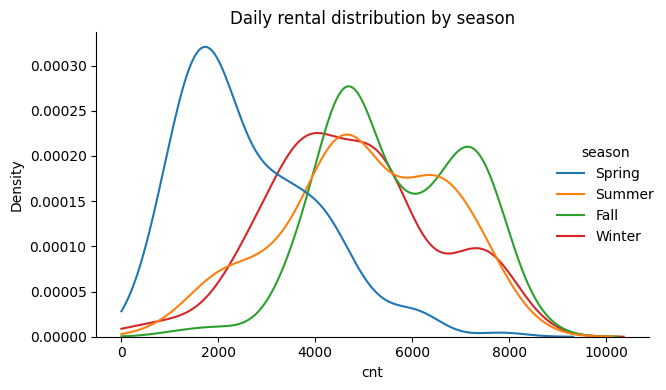

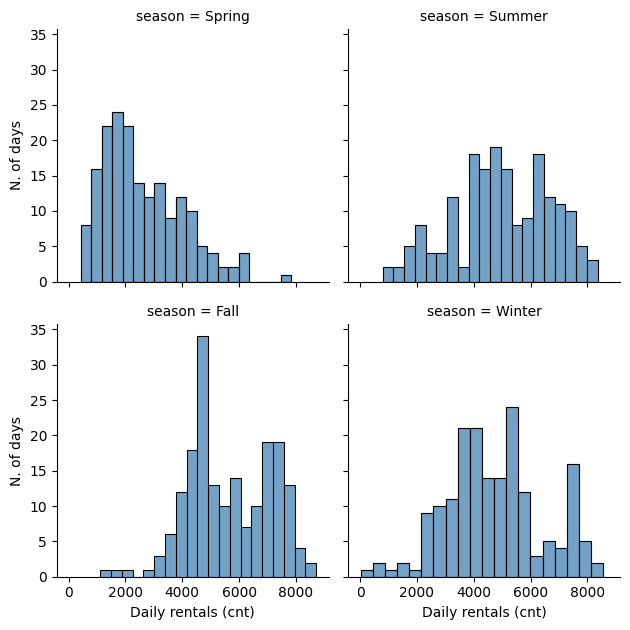

In [ ]:
##########################################
# 2.2.8) Exploring multimodality in `cnt`: visualize distplot (KDE) and histplot (histograms)
# KDE for each season (smoothed estimated histogram distro): basically show PDF for each season
sns.displot(
    data=day_df.assign(season=day_df['season'].map(season_map)),
    x='cnt',
    hue='season',
    kind='kde',
    clip=(0, None),
    fill=False,
    common_norm=False,
    height=4,
    aspect=1.4
).set(title='Daily rental distribution by season')
plt.tight_layout()
plt.show()
# Histograms for each seasonal distribution
g = sns.FacetGrid(
        day_df.assign(season=day_df['season'].map(season_map)),
        col='season',
        col_wrap=2,
        height=3.2
    )
g.map(sns.histplot, 'cnt', bins=20, color='steelblue')
g.set_axis_labels('Daily rentals (cnt)', 'N. of days')
plt.tight_layout()
plt.show()

### Remarks about the cell below
- `atemp` is so highly corr. with `temp` (0.99) that they are basically the same $\to$ drop
- `season` is highly corr. with `month` (0.83). However, since a) RFs don't suffer from highly correlated features that much, and b) I experimented with dropping `season` and this worsened the final test score $\to$ I decided to keep it

Index(['season', 'yr', 'mnth', 'holiday', 'weekday', 'workingday',
       'weathersit', 'temp', 'atemp', 'hum', 'windspeed', 'cnt'],
      dtype='object')


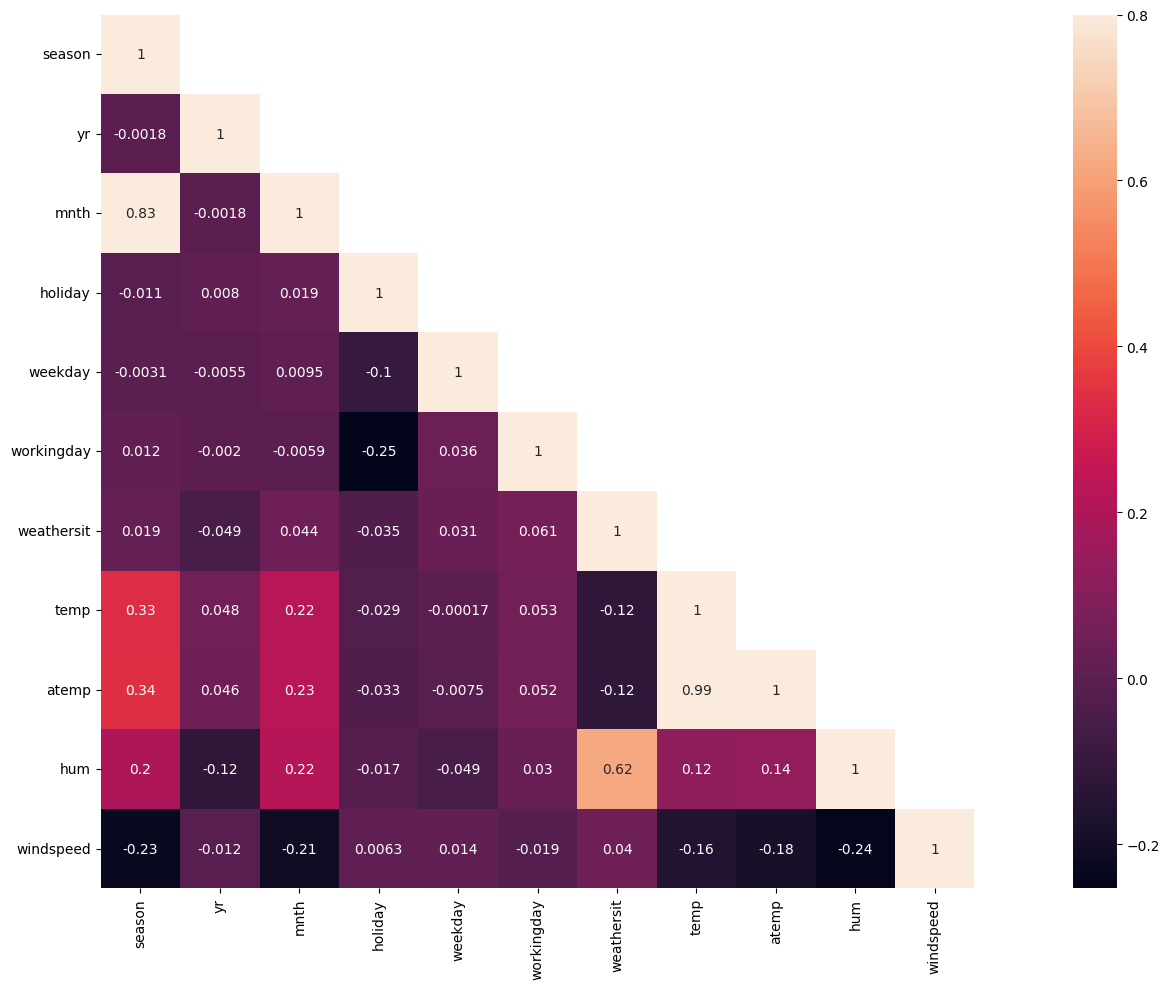

In [ ]:
##########################################
# 2.2.9) Visualize correlation matrix
print(day_df.columns)
corr = day_df[['season', 'yr', 'mnth', 'holiday', 'weekday', 'workingday',
       'weathersit', 'temp', 'atemp', 'hum', 'windspeed']].corr()
mask = np.array(corr)
mask[np.tril_indices_from(mask)] = False
fig, ax= plt.subplots()
fig.set_size_inches(20,10)
sns.heatmap(corr, mask=mask, vmax=.8, square=True, annot=True)
plt.tight_layout()
plt.show()

In [ ]:
##########################################
# 2.3)  Assume that each bike has exactly maximum 12 rentals per day
# - Find the maximum number of bicycles nmax that was needed in any one day.
# - Find the 95%-percentile of bicycles n95 that was needed in any one day.
##########################################
# Compute the fleet size needed per day, assuming each bike is rented <=12 times daily (convert to int)
day_df['daily_fleet_size'] = np.ceil(day_df['cnt'] / 12).astype(int)
# Compute stats:
#   - `nmax`: fleet size needed to cover demand on "busiest" day
#   - `n95`: 95-th percentile fleet size on (smallest fleet inventory that would have covered 95% of days)
nmax = day_df['daily_fleet_size'].max()
n95  = int(np.ceil(np.percentile(day_df['daily_fleet_size'], 95)))
n50  = int(np.ceil(np.percentile(day_df['daily_fleet_size'], 50)))
print(f"Number of bikes needed on busiest day (nmax): {nmax}")
print(f"Smallest number of bikes to cover 95% of days (n95): {n95}")
print()

Number of bikes needed on busiest day (nmax): 727
Smallest number of bikes to cover 95% of days (n95): 632



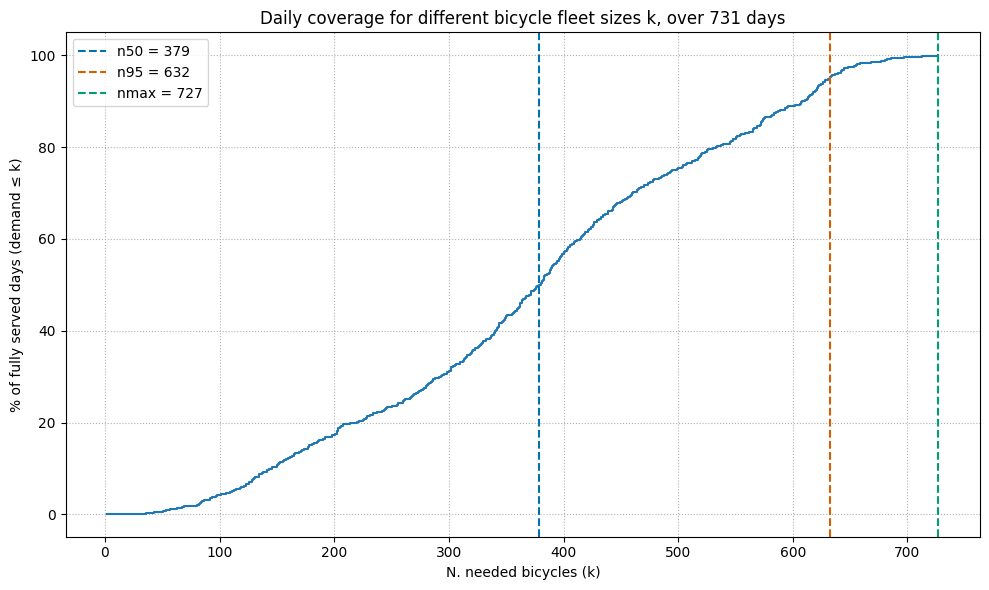

In [ ]:
##########################################
# 2.4)  Visualize the distribution of the covered days depending on the number of available bicycles.
#       E.g. `nmax` bicycles would cover 100% of days, `n95` covers 95%, etc.
##########################################
# Build "coverage" curve. For every `daily_fleet_size` value k, compute proportion of days with demand <= k.
# Basically, compute empirical CDF (in %): P("bikes needed" <= k)) in [0,1]
coverage_df = (
    day_df['daily_fleet_size']
    .value_counts() # for each `daily_fleet_size` value k, count n. of days which required exactly k bikes (Series, indexed by k)
    .sort_index() # sort by bike count k (ascending)
    .cumsum() # running cumulative sum, represents days where <= k bikes needed
    / len(day_df) * 100 # convert into percentage ~CDF
    ).reset_index().rename(columns={'daily_fleet_size': 'k', 'count': 'emp_CDF'})
# Plot: needed fleet size `k` vs %of days covered `emp_CDF`
plt.figure(figsize=(10, 6))
# Empirical CDF is flat until a new value of k is attained, then jumps up:
#   - `plt.step`: draws that step-curve
#   - `where='post'`: means hold current CDF value until next x-tick (i.e., next CDF value is attained), then jump
plt.step(coverage_df['k'], coverage_df['emp_CDF'], where='post')
# Vertical dashed line at 50th, 95th and 100th (max) percentiles of fleet size
plt.axvline(n50, linestyle='--', label=f'n50 = {n50}', color='#0072B2')
plt.axvline(n95, linestyle='--', label=f'n95 = {n95}', color='#D55E00')
plt.axvline(nmax, linestyle='--', label=f'nmax = {nmax}', color='#009E73')
plt.xlabel('N. needed bicycles (k)')
plt.ylabel('% of fully served days (demand ≤ k)')
plt.title(f'Daily coverage for different bicycle fleet sizes k, over {len(day_df)} days')
plt.grid(True, linestyle=':') # light dotted grid
plt.legend()
plt.tight_layout()
plt.show()

## Part 3 - Building prediction models

**Tasks:**
1. Define a test metric for predicting the daily demand for bike sharing, which you would like to use to measure the accuracy of the constructed models, and explain your choice.
2. Build a demand prediction model with Random Forest, preferably making use of following python libraries: scikit-learn.
3. Report the value of the chosen test metric on the provided data.

In [ ]:
##########################################
# Data
X = day_df.copy(deep=True)
X = day_df.copy(deep=True).drop(columns=['daily_fleet_size'])
y = X['cnt']
print(f'Columns before any feature engineering: {X.columns.values}')
print()

Columns before any feature engineering: ['season' 'yr' 'mnth' 'holiday' 'weekday' 'workingday' 'weathersit' 'temp'
 'atemp' 'hum' 'windspeed' 'cnt']



### 3.0) Feature engineering: log (Box-Cox) transform + revert
-   **Compresses outliers**, reducing their relative importance $\to$ now big and small rental days (e.g. vv hot or vv cold days) are comparable on an "additive scale", and additive effects should be more easily"measured"/"estimated" by models than multiplicative effect. So, our trees will tolerate more error on these outliers while being more accurate on the bulk of data.
-   **Var is more uniform/stabilized**, while not changing the ranking of the values $\to$ improved split-point detection in decision trees. What happens is that, in RFs, each tree make splits by minimizing the variance of the children (impurity-based); in the end, since the label/prediction at the leaves is a mean, on the leaves RF basically minimize the sum of variances. Now, if the target is skewed, outliers will affect the variances and worsen splits: split points are pushed towards the outliers, as a tree tries to "isolate" the tail from the remaining points $\to$ trees will be more affected by outliers if data is not transformed, i.e., they will predict outliers more accurately

See empirical performance at end, showcasing a superior performance with log-transform

### 3.1) Define a test metric for predicting the daily demand for bike sharing, which you would like to use to measure the accuracy of the constructed models, and explain your choice.

Chosen: Root Mean Squared Log Error (RMSLE)
- each summand in the loss is roughly equivalent to $\log^2\left(\dfrac{y_i}{\hat{y_i}}\right)$, with $\hat{y_i} a prediction and $y_i$ a label
- **asymmetric costs**: RMSLE yields a larger penalty for under-predictions: basically grows exponentially for underpredictions and less than logarithmically for overprediction. This is more useful than, say, MAE and MSE, which are "cost-symmetric" (no difference between under and over predictions). In fact, while over-predicting might not a big issue (e.g., if we prepared more bikes at a spot for one day, we could always move some during the night...or have them at the ready for the day after, the assumption being that people are always willing to move a bit to get to a bike), but under-predicting is bad because we cannot satisfy demand and thus lose money
- **robustness to outliers**: the log makes it robust to outliers, with similar considerations as the ones made about the log-transform. Useful considering that the data in `cnt` has a wide range of values (almost 3 orders of magnitude, from 22 to 8714). Also useful because it can predict relative errors well, and we are more interested in them than absolute errors (for instance, predicting 9 instead of 10 has the same RMSLE as predicting 900 instead of 10000).


### Remarks about the cells below
#### About Pipelines
I used sklearn's Pipelines used, so in the cells below I define some helper functions or classes that I will call in `eval_pipeline`, which
1. performs a train/test split $\to$ see `Month20tr10teSplit` and `Last30DaysSplit`
2. does feature engineering and potentially applies target transformation $\to$ see `preprocess` (applying no feature engineering), `one_hot_no_sparse` (setting up a one-hot encoder), `BikeFeatureEngineer`. This last one contains:
  - drop highly correlated features
  - compute cyclical sin/cos transformation features, important because they enforce continuity (e.g. Monday is close to Sunday)
  - optionally, add autoregressive features using past data: 1-day lag and 7-day rolling median. Note that this does not leak info and is feasible for production
3. fits a predictor, then evaluates it on a test set $\to$ see `eval_pipeline`

#### About splits
I decided to not only use the "Sixt" split, considering only the last month as a test set, but also an additional split using the first 20 days of all months as the training set, and the rest as the test set. Scores obtained by evaluating the predictor in the first case could be "just lucky", and in fact they tend to be slightly better (see below, smaller error).
I decided not to use a random split, inasmuch as it would leak future info

In [ ]:
##########################################
# 3.2) Build a demand prediction model with Random Forest, preferably making use of following python libraries: scikit-learn.

##########################################
# 3.2.1) Custom splitters
class Month20tr10teSplit(BaseCrossValidator):
    """
        Custom split: train on first 20 days of each month, test on the rest.
        Inherits from `BaseCrossValidator`, must reimplement `get_n_splits()` and `split()`.
    """
    # just one (`1`) big, global train/test split
    def get_n_splits(self, X=None, y=None, groups=None):
        return 1

    # Produce exactly 1 (train_indices, test_indices) pair, since `get_n_splits()` returns 1
    def split(self, X, y=None, groups=None):
        idx = X.index # Grab DatetimeIndex (set earlier) and store it into `idx`
        train_idx, test_idx = [], []

        # One loop per calendar month
        #   -   `idx.to_period('M')` turns every timestamp into its month, say 2011-04
        #   -   `.unique()` lists each month once --> loop runs 24 times (two years)
        for month in idx.to_period('M').unique():
            month_mask = idx.to_period('M') == month # select current month data
            # Select row numbers for current month, by accessing 1st element of `np.where` result tuple (row position where mask is true)
            days = np.where(month_mask)[0]
            # Append all calendar rows at once
            train_idx.extend(days[:20])
            test_idx.extend(days[20:])

        # Return generator for sklearn (must be np arrays)
        yield np.array(train_idx), np.array(test_idx)

class Last30DaysSplit(BaseCrossValidator): # "Sixt" split
    """
        Single split: train on rows [0 ... N-31], test on rows [N-30 ... N-1].
        Assumes X,y are already time-ordered from oldest to newest.
    """

    # Determine number of many pairs `split()` yields
    def get_n_splits(self, X=None, y=None, groups=None):
        return 1

    # Generator
    def split(self, X, y=None, groups=None):
        n_samples = len(X)
        if n_samples < 31:
            raise ValueError('Need at least 31 rows for a 30-day hold-out.')

        split_point = n_samples - 30 # first index in the test block
        train_idx = np.arange(0, split_point) # all integers btw 0 and `split_point`
        test_idx = np.arange(split_point, n_samples)

        yield train_idx, test_idx

In [ ]:
##########################################
# 3.2.2) NO Feature engineering
# all columns but `cnt`
feat_cols = [c for c in X.columns if c != 'cnt']
# "Preprocess-only" block used by to perform *no* feature engineering
preprocess = ColumnTransformer([('keep_all', 'passthrough', feat_cols)], remainder='drop')

In [ ]:
##########################################
# 3.2.3) Feature engineering
# Helper for one-hot encoding, implements `pd.get_dummies(..., drop_first=True)` and handles compatibility issues
def onehot_no_sparse():
    """Return `OneHotEncoder` with dense output, compatible with all sklearn versions."""
    # Grab signature of sklearn's `OneHotEncoder` constructor and pull its
    #   arguments, to check if newer `sparse_output` parameter exists
    params = inspect.signature(OneHotEncoder).parameters
    if 'sparse_output' in params: # sklearn >= 1.2
        # Drop first value to avoid collinearity, sparse bc few values and small dataset
        return OneHotEncoder(drop='first', sparse_output=False, dtype=np.float32)
    return OneHotEncoder(drop='first', sparse=False, dtype=np.float32) # sklearn < 1.2

class BikeFeatureEngineer(BaseEstimator, TransformerMixin):
    """
        Feature engineering class, inherits from `BaseEstimator`, `TransformerMixin`:
        -   drops 'atemp'
        -   one-hot encodes 'weathersit' (drops first binary column)
        -   adds sin/cos transformation pairs for month, season, weekday. Then drops ogs
        -   creates 1-day lag and rolling 7-day median from past data + drops `cnt`

        Works with/returns a Pandas DataFrame, so column names survive
    """
    def __init__(self, add_lag1=True, add_roll7=True):
        self.ohe = onehot_no_sparse() # Set up a `OneHotEncoder`
        self.weather_cols_ = ['weathersit'] # Stores column to OH encode
        self.add_lag1 = add_lag1
        self.add_roll7 = add_roll7

    # Nothing to learn except one-hot encoder
    def fit(self, X, y=None):
        X_ = X.copy() # Don't alter og data
        self.ohe.fit(X_[self.weather_cols_]) # learn OHE variable mapping
        return self

    # Feature engineering
    def transform(self, X):
        X_ = X.copy()

        # 1) Drop highly-correlated `atemp`
        if 'atemp' in X_.columns:
            X_ = X_.drop(columns='atemp')

        # 2) One-hot encode weather
        weather_ohe = self.ohe.transform(X_[self.weather_cols_])
        # Fetch colnames that the fitted OHE will output for the encoded weather feature
        ohe_names = self.ohe.get_feature_names_out(self.weather_cols_)
        X_.drop(columns=self.weather_cols_, inplace=True) # Drop og column, not needed anymore
        X_[ohe_names] = weather_ohe # add one-hot matrix to `X_`

        # 3) Cyclic calendar features
        X_['mnth_sin'] = np.sin(2*np.pi*X_['mnth'] / 12)
        X_['mnth_cos'] = np.cos(2*np.pi*X_['mnth'] / 12)
        X_['season_sin'] = np.sin(2*np.pi*X_['season'] / 4)
        X_['season_cos'] = np.cos(2*np.pi*X_['season'] / 4)
        X_['weekday_sin'] = np.sin(2*np.pi*X_['weekday']/ 7)
        X_['weekday_cos'] = np.cos(2*np.pi*X_['weekday']/ 7)
        X_ = X_.drop(columns=['mnth', 'season', 'weekday'])

        # 4) Autoregressive features
        if self.add_lag1:
            # After `shift(1)`, row-0 becomes NaN (no "yesterday" is available for day 0).
            # --> `bfill()` back-fills those NaN values: copies the next available value (day 1) upward
            # `min_periods=1` returns a statistic even when the window is not full
            X_['cnt_lag1'] = X_['cnt'].shift(1).bfill()
        if self.add_roll7:
            X_['cnt_roll7'] = (X_['cnt'].shift(1).rolling(7, min_periods=1).median().bfill())

        # Drop current-day `cnt` to avoid leakage
        if 'cnt' in X_.columns:
            X_.drop(columns='cnt', inplace=True)
        return X_

In [ ]:
##########################################
# 3.2.4) Pipeline evaluation
def eval_pipeline(pipe, X, y, cv):
    scores = cross_val_score(
        pipe, # Clone pipeline/estimator
        X, y, # Data
        cv = cv, # Splitting procedure
        scoring = 'neg_root_mean_squared_log_error' # returns -RMSLE
        )
    return -scores.mean()

In [ ]:
# Instantiate the two splitters
cv_20_10  = Month20tr10teSplit()
cv_last30 = Last30DaysSplit()

#### About baselines
I decided to use two "autoregressive" baselines.
Rationale: this is what we would do if we could not use ML. We would use past data, either 1-day lag or 7-day rolling median.


In [ ]:
##########################################
# 3.2.5) Simple autoregressive baseline
def baseline_scores(y, splitter):
    """
        Return RMSLE for two autoregressive baselines on the test indices generated by `splitter`.
    """
    for _, test_idx in splitter.split(X): # only one split
        y_test = y.iloc[test_idx]

        # 1-day lag predictor: "use yesterday's data to allocate bikes"
        y_pred_lag1 = y.shift(1).iloc[test_idx]
        rmsle_lag1  = root_mean_squared_log_error(y_test, y_pred_lag1)

        # 7-day rolling median predictor: "use median of rolling past week data to allocate bikes"
        y_pred_roll7 = (y.shift(1).rolling(7, min_periods=1).median()).iloc[test_idx]
        rmsle_roll7  = root_mean_squared_log_error(y_test, y_pred_roll7)

    return rmsle_lag1, rmsle_roll7

# Evaluate autoregressive baselines on the same splitters as for RF, below
lag1_30, roll7_30   = baseline_scores(y, cv_last30)
lag1_2010, roll7_2010 = baseline_scores(y, cv_20_10)
print(f'Last-30 split baseline 1-day lag, RMSLE : {lag1_30:.6f}')
print(f'Last-30 split baseline rolling 7-day median, RMSLE : {roll7_30:.6f}')
print(f'20-10 split baseline rolling 7-day median, RMSLE : {lag1_2010:.6f}')
print(f'20-10 split baseline rolling 7-day median, RMSLE : {roll7_2010:.6f}')
print()

Last-30 split baseline 1-day lag, RMSLE : 0.452465
Last-30 split baseline rolling 7-day median, RMSLE : 0.554550
20-10 split baseline rolling 7-day median, RMSLE : 0.583041
20-10 split baseline rolling 7-day median, RMSLE : 0.549061



In [ ]:
##########################################
# 3.2.6) Our Base regressor and splitters
rf = RandomForestRegressor(
    n_estimators = 50,
    min_samples_leaf = 2,
    criterion = 'friedman_mse',
    random_state = 42)

#### About test results (autoregressive baselines VS simple RF baseline)
- `cv_last30` split: autocorrelation is strong and, in a sense, bike rental demand is persistent to the 1-day lag. In fact:
  - the 1-day lag autoregressive baseline is good, actually better than our naive random forest with og-scaled target and no feature engineering. Also,
  - our RF is better, on this split, when autoregressive feature are used
- `cv_20_10` split: our RF is already better than the autoregressive baselines on this "more challenging split". Our calendar+weather RF improves once we stabilise variance (with log-target) and add basic feature engineering. Autoregressive features worsen the test scores. It would be interesting to perform experiments on a larger dataset
- the log-transform (transform `y_train`, then backtransform `y_pred` before computing the RMSLE) always yields better test results

#### Takeaways
- `cv_last30`: our best model (with feature engineering including autoregressive features, and target log-transform) reduces the 1-day lag baseline error by about $18\%$, and the 7-day rolling median baseline by about $33\%$.
- `cv_last30`: on this tougher split, our best model (with feature engineering not including autoregressive features, and target log-transform) reduces the 1-day lag baseline error by about $19\%$, and the 7-day rolling median baseline by about $14\%$.
- **log-transform**: always produces improvements in test error: at least $2\%$ and as much $16\%$
- **autoregressive features**: could be useful but to be verified with larger dataset

In [ ]:
##########################################
# 3.2.7) Evaluate our pipeline without feature engineering
##########################################
# Raw pipeline without log-transform
pipe_raw = Pipeline([
    ('prep' , preprocess),
    ('model', rf)
])
##########################################
# Pipeline with log-transform and back
pipe_logtransf = Pipeline([
    ('prep' , preprocess),
    ('model', TransformedTargetRegressor(
        regressor = rf,
        func = np.log1p,   # log-transform `y_train`
        inverse_func = np.expm1)) # revert `y_pred` to og scale to compute RMSLE
])
rmsle_last30_raw = eval_pipeline(pipe_raw, X, y, cv_last30)
rmsle_last30_log = eval_pipeline(pipe_logtransf, X, y, cv_last30)
rmsle_20_10_raw = eval_pipeline(pipe_raw, X, y, cv_20_10)
rmsle_20_10_log = eval_pipeline(pipe_logtransf, X, y, cv_20_10)
print(f"Last30 split, RMSLE raw : {rmsle_last30_raw:.6f}")
print(f"Last30 split, RMSLE log : {rmsle_last30_log:.6f}")
print(f"20-10 split,  RMSLE raw : {rmsle_20_10_raw:.6f}")
print(f"20-10 split,  RMSLE log : {rmsle_20_10_log:.6f}")
print()

Last30 split, RMSLE raw : 0.516884
Last30 split, RMSLE log : 0.432631
20-10 split,  RMSLE raw : 0.514519
20-10 split,  RMSLE log : 0.498438



In [ ]:
##########################################
# 3.2.8) Evaluate our pipeline with feature engineering but without autoregressive features
##########################################
# Raw pipeline without log-transform, with FE (no autoregressive FE)
pipe_fe_raw = Pipeline([
    ('fe'  , BikeFeatureEngineer(add_lag1=False, add_roll7=False)),
    ('model', rf)
])
##########################################
# Pipeline with log-transform and back, with FE (no autoregressive FE)
pipe_fe_logtransf = Pipeline([
    ('fe'  , BikeFeatureEngineer(add_lag1=False, add_roll7=False)),
    ('model', TransformedTargetRegressor(
        regressor    = rf,
        func         = np.log1p,
        inverse_func = np.expm1))
])
rmsle_fe_last30_raw = eval_pipeline(pipe_fe_raw, X, y, cv_last30)
rmsle_fe_last30_log = eval_pipeline(pipe_fe_logtransf, X, y, cv_last30)
rmsle_fe_20_10_raw = eval_pipeline(pipe_fe_raw, X, y, cv_20_10)
rmsle_fe_20_10_log = eval_pipeline(pipe_fe_logtransf, X, y, cv_20_10)
print(f"Last30 split + FE (no AR), RMSLE raw : {rmsle_fe_last30_raw:.6f}")
print(f"Last30 split + FE (no AR), RMSLE log : {rmsle_fe_last30_log:.6f}")
print(f"20-10 split + FE (no AR),  RMSLE raw : {rmsle_fe_20_10_raw:.6f}")
print(f"20-10 split + FE (no AR),  RMSLE log : {rmsle_fe_20_10_log:.6f}")
print()

Last30 split + FE (no AR), RMSLE raw : 0.467769
Last30 split + FE (no AR), RMSLE log : 0.407435
20-10 split + FE (no AR),  RMSLE raw : 0.474683
20-10 split + FE (no AR),  RMSLE log : 0.459089



In [ ]:
##########################################
# 3.2.9) Evaluate our pipeline with feature engineering including autoregressive features
##########################################
# Raw pipeline without log-transform, with FE (including autoregressive FE)
pipe_fe_ar_raw = Pipeline([
    ('fe'  , BikeFeatureEngineer()),
    ('model', rf)
])
##########################################
# Pipeline with log-transform and back, with FE (including autoregressive FE)
pipe_fe_ar_logtransf = Pipeline([
    ('fe'  , BikeFeatureEngineer()),
    ('model', TransformedTargetRegressor(
        regressor    = rf,
        func         = np.log1p,
        inverse_func = np.expm1))
])
rmsle_fe_ar_last30_raw = eval_pipeline(pipe_fe_ar_raw, X, y, cv_last30)
rmsle_fe_ar_last30_log = eval_pipeline(pipe_fe_ar_logtransf, X, y, cv_last30)
rmsle_fe_ar_20_10_raw = eval_pipeline(pipe_fe_ar_raw, X, y, cv_20_10)
rmsle_fe_ar_20_10_log = eval_pipeline(pipe_fe_ar_logtransf, X, y, cv_20_10)
print(f"Last30 split + FE (with AR), RMSLE raw : {rmsle_fe_ar_last30_raw:.6f}")
print(f"Last30 split + FE (with AR), RMSLE log : {rmsle_fe_ar_last30_log:.6f}")
print(f"20-10 split + FE (with AR),  RMSLE raw : {rmsle_fe_ar_20_10_raw:.6f}")
print(f"20-10 split + FE (with AR),  RMSLE log : {rmsle_fe_ar_20_10_log:.6f}")
print()

Last30 split + FE (with AR), RMSLE raw : 0.435455
Last30 split + FE (with AR), RMSLE log : 0.372448
20-10 split + FE (with AR),  RMSLE raw : 0.482633
20-10 split + FE (with AR),  RMSLE log : 0.475147



# Potential improvements
-   Hyperparameter tuning of the RF
-   Add more features:
  - autoregressive: rolling mean instead of median, or as well as rolling median; lag-based feature, not only computed from `cnt` but also from `casual` and `registered`(if not heavily correlated with `cnt`)
  - weather: "pleasant_weather", for example if temp > 0.5 and hum < 0.6. For this, I would read in detail the paper that created the UCI dataset, plus articles on how weather and bike rental forecasts are related, etc.
- Explore feature importance
- Try new models
  - Gradient-boosted trees: they keep learning from the errors of previous trees, thus reducing bias and capturing subtler patterns than an RF, which just averages many independent trees
  - Time-series specific (maybe, if not even GBT works?): something like Prophet? Would need further exploration...
- The dataset is very tiny so the model might not be learning a lot: try retraining after gathering more data


## References

[1] Lichman, M. (2013). UCI Machine Learning Repository [http://archive.ics.uci.edu/ml]. Irvine, CA: University of California, School of Information and Computer Science.